<a href="https://colab.research.google.com/github/carolineh-csuf/CPSC531_spark_cnn/blob/main/CPSC531_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!date

Thu Nov  7 06:28:46 PM UTC 2024


In [8]:
!pip install pyngrok

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import requests

# Set the WebHDFS URL for your HDFS path
hdfs_url = 'https://412d-72-203-109-177.ngrok-free.app/webhdfs/v1/cifar10/cifar-10-batches-py?op=LISTSTATUS'

# Send GET request to WebHDFS
response = requests.get(hdfs_url)

if response.status_code == 200:
    # Successfully retrieved the list of files
    print("Files in HDFS directory:", response.json())
else:
    # Failed to access HDFS
    print("Failed to access HDFS:", response.text)


Files in HDFS directory: {'FileStatuses': {'FileStatus': [{'accessTime': 1730922301278, 'blockSize': 134217728, 'childrenNum': 0, 'fileId': 16423, 'group': 'supergroup', 'length': 158, 'modificationTime': 1730845402943, 'owner': 'carolineha', 'pathSuffix': 'batches.meta', 'permission': '644', 'replication': 1, 'storagePolicy': 0, 'type': 'FILE'}, {'accessTime': 1730921854010, 'blockSize': 134217728, 'childrenNum': 0, 'fileId': 16421, 'group': 'supergroup', 'length': 31035704, 'modificationTime': 1730845402450, 'owner': 'carolineha', 'pathSuffix': 'data_batch_1', 'permission': '644', 'replication': 1, 'storagePolicy': 0, 'type': 'FILE'}, {'accessTime': 1730922301824, 'blockSize': 134217728, 'childrenNum': 0, 'fileId': 16424, 'group': 'supergroup', 'length': 31035320, 'modificationTime': 1730845403053, 'owner': 'carolineha', 'pathSuffix': 'data_batch_2', 'permission': '644', 'replication': 1, 'storagePolicy': 0, 'type': 'FILE'}, {'accessTime': 1730918428885, 'blockSize': 134217728, 'chil

In [ ]:
# import requests
# import pickle

# # 通过 ngrok 提供的 URL 访问本地文件
# url = 'https://f033-72-203-109-177.ngrok-free.app/data_batch_1.bin'
# response = requests.get(url)

# # 检查请求是否成功
# if response.status_code == 200:
#     print("访问成功", response.status_code)
# else:
#     print("无法访问文件：", response.status_code)

访问成功 200


In [10]:
from pyngrok import ngrok

# 替换成您在 ngrok 控制面板上获取的 authtoken
ngrok.set_auth_token("2oU9FWQy4SY68l3snyLWgtfQrg4_4y2tRo9RyEhZvHbnfxjX")


# 打开端口 4040
public_url = ngrok.connect(4040)
print(f'Spark UI can be accessed at {public_url}')

Spark UI can be accessed at NgrokTunnel: "https://b281-34-169-66-88.ngrok-free.app" -> "http://localhost:4040"


In [12]:
!pip install findspark pyspark

In [14]:
import findspark
findspark.init()

#from pyspark.sql import SparkSession

#spark = SparkSession.builder.master("local").appName("SparkUIExample").getOrCreate()

In [4]:
import pickle
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession

# 创建 SparkSession
spark = SparkSession.builder.appName("CIFAR-10").getOrCreate()

# 读取 CIFAR-10 数据批次文件
def load_cifar10_batch(batch_file):
    with open(batch_file, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')  # 需要使用 bytes 编码，支持 Python 2 和 3
    images = data_dict[b'data']  # 图像数据
    labels = data_dict[b'labels']  # 标签数据

    # 将图像数据从 (N, 3072) 转换为 (N, 32, 32, 3) 格式
    images = images.reshape((len(images), 3, 32, 32)).transpose(0, 2, 3, 1)  # 转换为 (num_images, 32, 32, 3)

    return images, labels

# 示例：读取一个 CIFAR-10 批次文件
images, labels = load_cifar10_batch('/content/drive/MyDrive/cifar-10-batches-py/data_batch_1')

# 打印图像数据的形状和标签数量
print(images.shape)  # 输出 (num_images, 32, 32, 3)
print(len(labels))   # 标签的数量


# 将图像数据展平为一维数组并与标签配对
# 注意：由于图像是3D数组（32x32x3），所以我们需要将其展平为一维数组
flattened_images = images.reshape(images.shape[0], -1)  # 展平为 (num_images, 3072)

# 将数据转换为 Pandas DataFrame
import pandas as pd
df = pd.DataFrame(flattened_images)
df['labels'] = labels  # 添加标签列

# 将 Pandas DataFrame 转换为 Spark DataFrame
spark_df = spark.createDataFrame(df)

# 查看数据结构
spark_df.printSchema()

# 显示前几行数据
spark_df.show()


(10000, 32, 32, 3)
10000
root
 |-- 0: long (nullable = true)
 |-- 1: long (nullable = true)
 |-- 2: long (nullable = true)
 |-- 3: long (nullable = true)
 |-- 4: long (nullable = true)
 |-- 5: long (nullable = true)
 |-- 6: long (nullable = true)
 |-- 7: long (nullable = true)
 |-- 8: long (nullable = true)
 |-- 9: long (nullable = true)
 |-- 10: long (nullable = true)
 |-- 11: long (nullable = true)
 |-- 12: long (nullable = true)
 |-- 13: long (nullable = true)
 |-- 14: long (nullable = true)
 |-- 15: long (nullable = true)
 |-- 16: long (nullable = true)
 |-- 17: long (nullable = true)
 |-- 18: long (nullable = true)
 |-- 19: long (nullable = true)
 |-- 20: long (nullable = true)
 |-- 21: long (nullable = true)
 |-- 22: long (nullable = true)
 |-- 23: long (nullable = true)
 |-- 24: long (nullable = true)
 |-- 25: long (nullable = true)
 |-- 26: long (nullable = true)
 |-- 27: long (nullable = true)
 |-- 28: long (nullable = true)
 |-- 29: long (nullable = true)
 |-- 30: long (nulla

In [5]:
# 将数据集划分为训练集和验证集
train_df, val_df = spark_df.randomSplit([0.8, 0.2], seed=1234)

In [10]:
# 将训练集和验证集从 Spark DataFrame 转换为 Pandas DataFrame ？？？ 必要？？？？
train_pd = train_df.toPandas()
val_pd = val_df.toPandas()

# 将数据转换为 NumPy 数组
train_images = np.array(train_pd.drop('labels', axis=1))  # 删除标签列
train_labels = np.array(train_pd['labels'])  # 提取标签

val_images = np.array(val_pd.drop('labels', axis=1))  # 删除标签列
val_labels = np.array(val_pd['labels'])  # 提取标签

# 将数据转换为 PyTorch 数据集
train_images = train_images.reshape((-1, 3, 32, 32))  # CIFAR-10 图像尺寸 (N, 3, 32, 32)
val_images = val_images.reshape((-1, 3, 32, 32))

# 转换为 PyTorch Tensor
train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)

val_images = torch.tensor(val_images, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.long)


## 用于Resnet18 缩放
from torchvision import transforms

# 定义预处理过程
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 采用ImageNet的均值和标准差
])

## 用于Resnet18 缩放

# 创建 PyTorch DataLoader
train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_images, val_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


In [28]:
## ？？？？？？TO BE DELETE
import torch
import numpy as np

# # 假设 spark_df 已经准备好了，并且我们获取了图像和标签
# images = np.array(spark_df.drop('labels').collect())  # 删除标签列
# labels = np.array(spark_df.select('labels').collect()).flatten()  # 提取标签数据

# # 重新调整图像的形状 (N, 3, 32, 32)
# images = images.reshape((-1, 3, 32, 32))  # 转换为 (batch_size, channels, height, width)

# # 转换为 PyTorch 张量
# images_tensor = torch.tensor(images, dtype=torch.float32)
# labels_tensor = torch.tensor(labels, dtype=torch.long)

# 创建数据集和数据加载器
class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

#dataset = CIFAR10Dataset(images_tensor, labels_tensor)
#train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# 查看数据加载器中的一批数据
data_iter = iter(train_loader)
images_batch, labels_batch = next(data_iter)

print(images_batch.shape)  # 输出：torch.Size([64, 3, 32, 32])
print(labels_batch.shape)  # 输出：torch.Size([64])


torch.Size([64, 3, 32, 32])
torch.Size([64])


In [29]:
import torch.nn as nn
import torch.optim as optim

# 定义 CNN 模型
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # CIFAR-10 图像大小是 32x32，所以池化后是 8x8
        self.fc2 = nn.Linear(512, 10)  # 10 类别

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)  # 2x2 池化层
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)  # 2x2 池化层
        x = x.view(x.size(0), -1)  # 展平
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 初始化模型
model = CNNModel()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# # 训练模型
# epochs = 10
# for epoch in range(epochs):
#     model.train()  # 设置模型为训练模式
#     running_loss = 0.0
#     for images, labels in train_loader:
#         # 传入数据
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader)}")


Epoch [1/10], Loss: 0.0012
Validation Accuracy: 33.25%
Epoch [2/10], Loss: 0.0009
Validation Accuracy: 33.15%
Epoch [3/10], Loss: 0.0007
Validation Accuracy: 33.00%
Epoch [4/10], Loss: 0.0006
Validation Accuracy: 33.05%
Epoch [5/10], Loss: 0.0005
Validation Accuracy: 32.90%
Epoch [6/10], Loss: 0.0005
Validation Accuracy: 33.05%
Epoch [7/10], Loss: 0.0004
Validation Accuracy: 33.10%
Epoch [8/10], Loss: 0.0004
Validation Accuracy: 33.30%
Epoch [9/10], Loss: 0.0003
Validation Accuracy: 33.15%
Epoch [10/10], Loss: 0.0003
Validation Accuracy: 33.25%


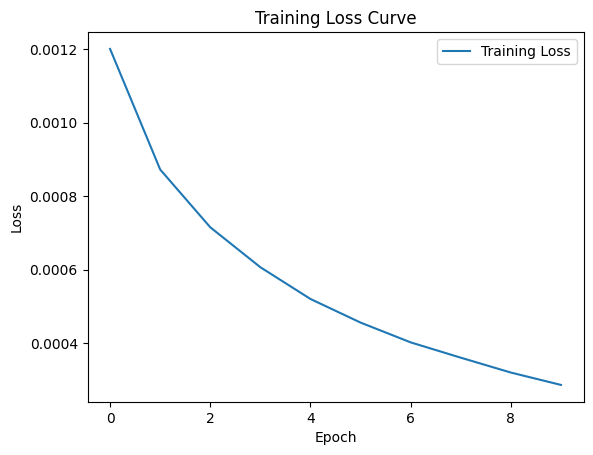

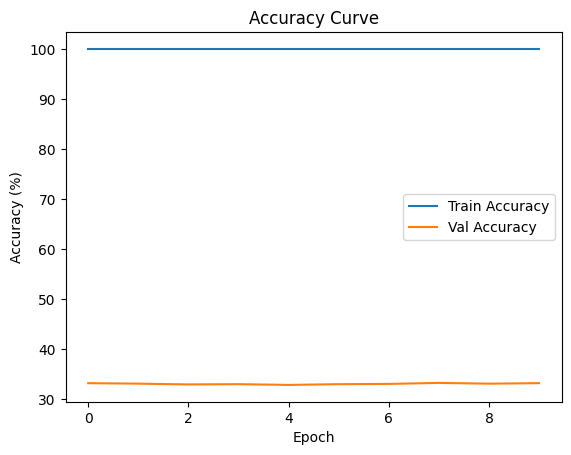

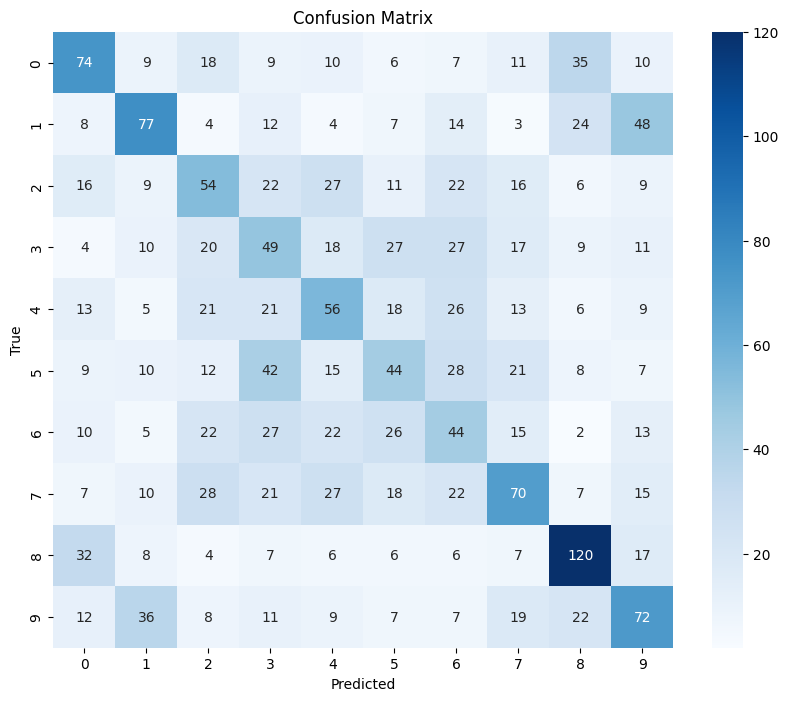

In [38]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns


# 用来存储每个 epoch 的损失
train_losses = []

# 用来存储每个 epoch 的训练和验证准确率
train_accuracies = []
val_accuracies = []

# 训练和验证循环
epochs = 10
for epoch in range(epochs):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0


    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    # 记录每个 epoch 的损失
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # 验证步骤
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0

    # 在验证集上计算混淆矩阵
    all_preds = []
    all_labels = []

    with torch.no_grad():  # 不计算梯度，节省内存
        for images, labels in val_loader:  # 使用验证集的 DataLoader
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # 获取预测结果
            total += labels.size(0)  # 统计总数
            correct += (predicted == labels).sum().item()  # 统计正确的数量

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())  # 将预测结果转换为numpy并添加到列表
            all_labels.extend(labels.numpy())  # 将标签转换为numpy并添加到列表


    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")




# 绘制损失曲线
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()



# 绘制准确率曲线
plt.plot(range(epochs), train_accuracies, label="Train Accuracy")
plt.plot(range(epochs), val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.show()



# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [11]:
#步骤 1: 导入必要的库并设置模型
import torch
import torch.nn as nn
from torchvision import models

# 加载预训练的 ResNet-18 模型
model = models.resnet18(pretrained=True)

# 修改最后的全连接层以适应 CIFAR-10 数据集（10 类输出）
model.fc = nn.Linear(model.fc.in_features, 10)

# 将模型设置为评估模式
model.eval()

# 将模型转移到 GPU 如果有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# 定义评估函数
def evaluate_model(model, val_loader, device):
    correct = 0
    total = 0

    # 不计算梯度，节省内存和加速推理
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 前向传播
            outputs = model(inputs)

            # 获取预测的标签
            _, predicted = torch.max(outputs, 1)

            # 统计准确率
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 计算准确率
    accuracy = 100 * correct / total
    return accuracy


In [14]:
# 在验证集上评估模型
accuracy = evaluate_model(model, val_loader, device)
print(f'Accuracy on the validation set: {accuracy:.2f}%')


Accuracy on the validation set: 9.62%
